# Poisson Equation in 1D with Dirichlet/Neumann Boundary Conditions

We will solve a Poisson equation in 1D:

$$
\triangle u = 2, \qquad \text{where} \quad x  \in [-1,1],
$$

with the Dirichlet boundary conditions on the left boundary:

$$
u(-1) = 0
$$

and with the Neumann boundary conditions on the right boundary:

$$
\left. \frac{du}{dx} \right|_{x=1} = 4.
$$

The exact solution is $u(x) = (x+1)^2$.

## Implementation and Training

First, we import the libraries:

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
import datetime

We define the minimum and maximum values of the domain.

In [2]:
x_min = -1.
x_max = 1.

Now, we set the parameters of the neural network: it has a structure with 1 input ($x$) and 1 output ($u(x)$), 5000 maximum training steps, 2 hidden layers with 16 neurons each, 40 samples and a target minimum loss value of $10^{-4}$.

In [3]:
inputs = 1
outputs = 1
hn_1 = 16
hn_2 = 16
steps = 0
max_steps = 5000
loss = 10
min_loss = 1e-4
log_each = 500
samples = 40
loss_values = []

The multilayer perceptron (MLP) structure is:

In [5]:
mlp = nn.Sequential(
    nn.Linear(inputs,hn_1),
    nn.Tanh(),
    nn.Linear(hn_1, hn_2),
    nn.Tanh(),
    nn.Linear(hn_2, outputs)
)

optimizer = torch.optim.Adam(mlp.parameters())
criterion = nn.MSELoss()
mlp.train()

Sequential(
  (0): Linear(in_features=1, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_features=16, out_features=1, bias=True)
)

In this section, we define a function that calculates the gradients.

In [6]:
def computeGrads(y, x):
    grads, = torch.autograd.grad(y, x, grad_outputs=y.data.new(y.shape).fill_(1), create_graph=True, only_inputs=True)
    return grads

Next, we define the main training loop and the timer:

In [7]:
starttime_train = datetime.datetime.now()
print('----Training Started----')

while steps < max_steps and loss > min_loss:
    X = (x_max - x_min)*torch.rand((samples, 1), requires_grad=True) + x_min
    Y = mlp(X)
    dudx = computeGrads(Y, X)
    d2udx2 = computeGrads(dudx, X)
    ode_loss = criterion(d2udx2, 2*torch.ones(samples, 1))

    #boundary condition in x=-1
    X_1 = -torch.ones(samples, 1)
    Y_1 = mlp(X_1)
    zero = torch.zeros(samples, 1)
    bc_1_loss = criterion(Y_1, zero)

    #boundary conditions x=1
    X1 = torch.ones(samples, 1)
    X1.requires_grad = True
    Y1 = mlp(X1)
    dudx1 = computeGrads(Y1, X1)
    four = 4*torch.ones(samples, 1)
    bc1_loss = criterion(dudx1, four)
    
    bc_loss = bc_1_loss + bc1_loss

    optimizer.zero_grad()
    loss = ode_loss + bc_loss
    loss.backward()
    optimizer.step()

    loss_values.append(loss.detach().numpy())

    if steps % log_each == 0:
        print(f'Step:{steps}| ode_loss {ode_loss.item():.5f} bc_loss {bc_loss.item():.5f}')

    steps+=1

endtime_train = datetime.datetime.now()
train_time = endtime_train - starttime_train
train_time_formatted = train_time.seconds + train_time.microseconds / 1e6
print('---Training Finished---')

print(f'Training Duration: {steps} steps in {train_time_formatted:.3f} seconds')

----Training Started----
Step:0| ode_loss 3.85428 bc_loss 16.09036
Step:500| ode_loss 0.14496 bc_loss 0.01414
Step:1000| ode_loss 0.00654 bc_loss 0.00003
Step:1500| ode_loss 0.00380 bc_loss 0.00001
Step:2000| ode_loss 0.00137 bc_loss 0.00000
Step:2500| ode_loss 0.00087 bc_loss 0.00000
Step:3000| ode_loss 0.00053 bc_loss 0.00002
---Training Finished---
Training Duration: 3483 steps in 5.742 seconds


## Visualization

To visualize the model and compare results, we obtain the output of the trained model and plot it alongside the exact solution.

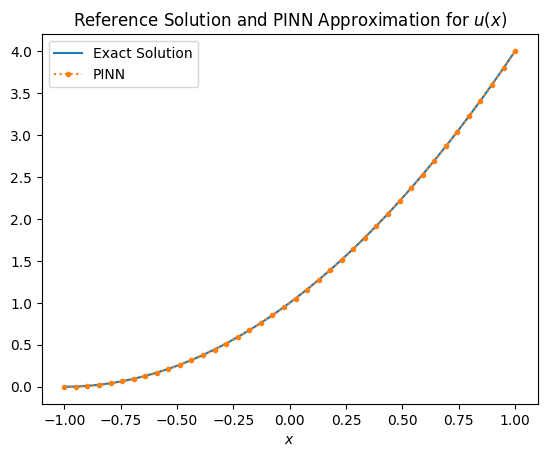

In [8]:
x = np.linspace(-1, 1, samples)

def sol(x):
    return (x + 1)**2

with torch.no_grad():
    X = torch.stack([torch.from_numpy(x).float()], axis=-1)
    Y = mlp(X)

result = Y.detach().numpy()

plt.figure()
plt.plot(x, sol(x), '-', label = 'Exact Solution')
plt.plot(x, result, '.:', label = 'PINN')
plt.title('Reference Solution and PINN Approximation for $u(x)$')
plt.xlabel('$x$')
plt.legend()